In [296]:
import pandas as pd
import yfinance as yf
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from full_fred.fred import Fred
import os

# Question 1
### 1a

In [247]:
# GLOBAL CONSTS
START_DATE = '2023-01-01'         # Start date for evaluation window
END_DATE = '2023-12-31'           # End date for evaluation window
SPTL_TICKER = 'SPTL'              # SPDR Portfolio Long Term Treasury ETF
EFFR_TICKER = 'EFFR'              # Effective Fed Funds Rate
FRED_API_KEY = 'FRED_API_KEY'     # Personal Fred API key location in os environ
TRADING_DAYS = 252                # Number of trading days per year

In [248]:
# Get index data from yfinance
yf_df = yf.Ticker(SPTL_TICKER).history(start=START_DATE, end=END_DATE).reset_index()
yf_cols = yf_df.columns
yf_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2023-01-03 00:00:00-05:00,27.511978,27.558249,27.188090,27.326900,3557300,0.0,0.0,0.0
1,2023-01-04 00:00:00-05:00,27.789606,27.826621,27.539749,27.669304,4448800,0.0,0.0,0.0
2,2023-01-05 00:00:00-05:00,27.447205,27.780348,27.410190,27.780348,2795600,0.0,0.0,0.0
3,2023-01-06 00:00:00-05:00,27.641544,28.289319,27.623036,28.261559,4309600,0.0,0.0,0.0
4,2023-01-09 00:00:00-05:00,28.076475,28.455887,28.039459,28.400364,2540300,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
245,2023-12-22 00:00:00-05:00,27.836191,27.845754,27.549318,27.635380,3040400,0.0,0.0,0.0
246,2023-12-26 00:00:00-05:00,27.625814,27.731001,27.625814,27.683189,3582900,0.0,0.0,0.0
247,2023-12-27 00:00:00-05:00,27.960502,28.161313,27.893565,28.151751,2680700,0.0,0.0,0.0
248,2023-12-28 00:00:00-05:00,28.046560,28.170870,27.903124,27.970060,3364900,0.0,0.0,0.0


In [258]:
# Manipulate yfinance data
YF_DATE = 'Date'
DATE_STRING = 'date_string'
yf_df[DATE_STRING] = yf_df[YF_DATE].dt.strftime('%Y-%m-%d')

In [251]:
# Get Fred data for EFFR
fred = Fred()
fred.env_api_key_found()
os.environ
fred_df = fred.get_series_df(EFFR_TICKER, observation_start=START_DATE, observation_end=END_DATE)

In [252]:
# Clean and manipulate Fred data
fred_cols = fred_df.columns
VALUE = 'value'                                                         # To avoid magic strings, this is the key for the VALUE column
FRED_DATE = 'date'
fred_df.loc[fred_df[VALUE] == '.', VALUE] = fred_df[VALUE].shift(-1)    # Replace all values that are '.' with the neighouring rows VALUE
fred_df = fred_df.astype({'value': 'float32'})                          # Adjust datatype of column
DAILY_RISK_FREE = 'daily_risk_free'                                     # Avoid magic string for column name
fred_df[DAILY_RISK_FREE] = fred_df[VALUE] / TRADING_DAYS                # Adding in day adjusted risk free
fred_df

,realtime_start,realtime_end,date,value,daily_risk_free
0,2025-03-20,2025-03-20,2023-01-02,4.33,0.017183
1,2025-03-20,2025-03-20,2023-01-03,4.33,0.017183
2,2025-03-20,2025-03-20,2023-01-04,4.33,0.017183
3,2025-03-20,2025-03-20,2023-01-05,4.33,0.017183
4,2025-03-20,2025-03-20,2023-01-06,4.33,0.017183
...,...,...,...,...,...
255,2025-03-20,2025-03-20,2023-12-25,5.33,0.021151
256,2025-03-20,2025-03-20,2023-12-26,5.33,0.021151
257,2025-03-20,2025-03-20,2023-12-27,5.33,0.021151
258,2025-03-20,2025-03-20,2023-12-28,5.33,0.021151


In [253]:
# Merge yf and Fred to have a combined dateframe, joined on date
merged_df = pd.merge(
    left=yf_df,
    right=fred_df,
    left_on=DATE_STRING,
    right_on=FRED_DATE,
    how='left'
)[['date', YF_DATE, DAILY_RISK_FREE, VALUE]]
merged_df

,date,Date,daily_risk_free,value
0,2023-01-03,2023-01-03 00:00:00-05:00,0.017183,4.33
1,2023-01-04,2023-01-04 00:00:00-05:00,0.017183,4.33
2,2023-01-05,2023-01-05 00:00:00-05:00,0.017183,4.33
3,2023-01-06,2023-01-06 00:00:00-05:00,0.017183,4.33
4,2023-01-09,2023-01-09 00:00:00-05:00,0.017183,4.33
...,...,...,...,...
245,2023-12-22,2023-12-22 00:00:00-05:00,0.021151,5.33
246,2023-12-26,2023-12-26 00:00:00-05:00,0.021151,5.33
247,2023-12-27,2023-12-27 00:00:00-05:00,0.021151,5.33
248,2023-12-28,2023-12-28 00:00:00-05:00,0.021151,5.33


In [260]:
# Calculate the daily excess returns
DLY_RTNS = 'daily_returns'
DLY_XS_RTNS = 'daily_excess_returns'
yf_df[DLY_RTNS] = (yf_df['Close'] - yf_df['Close'].shift(1)) / yf_df['Close']    # Check this for the index
yf_df[DLY_XS_RTNS] = yf_df[DLY_RTNS] - merged_df[DAILY_RISK_FREE]


### 1b

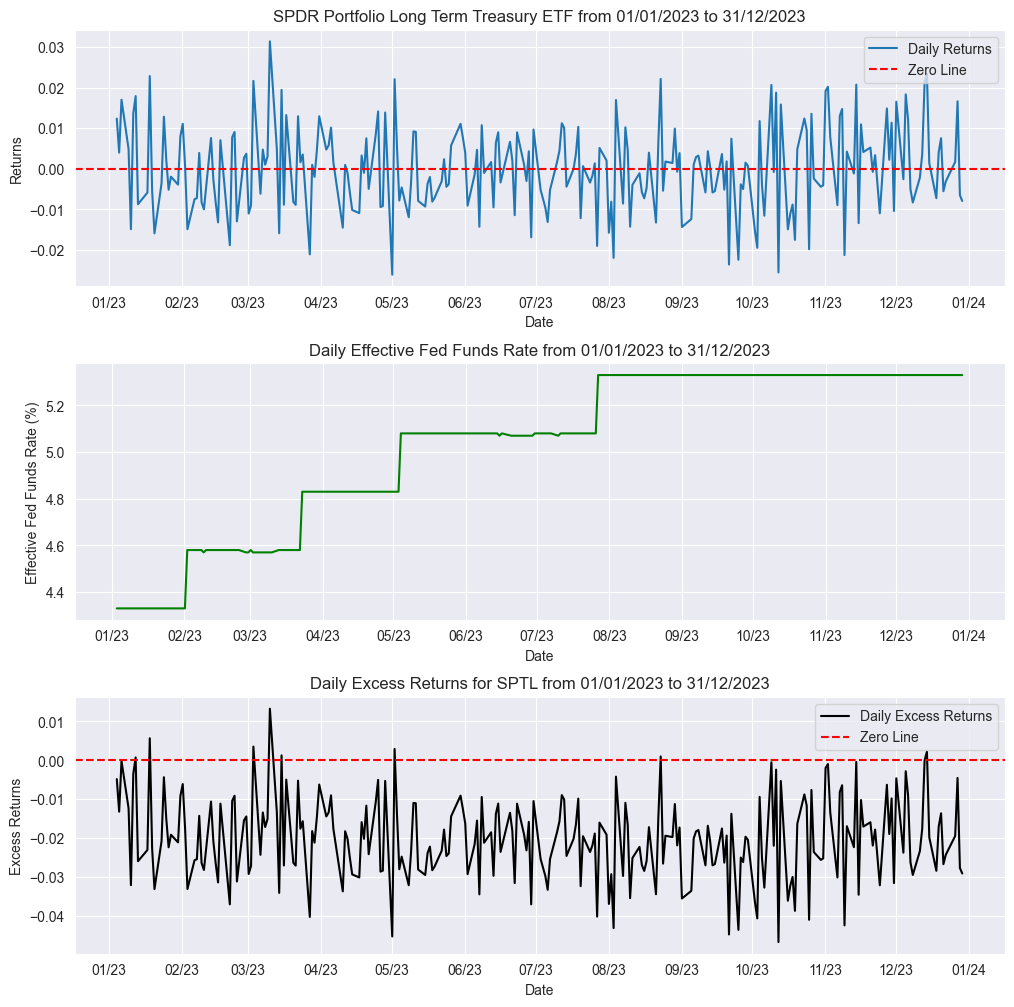

In [ ]:
# Plotting data
sns.set_style("darkgrid")
start_formatted = date.fromisoformat(START_DATE).strftime('%d/%m/%Y')
end_formatted = date.fromisoformat(END_DATE).strftime('%d/%m/%Y')

# Create plots on subplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3)

# Daily returns
ax1.plot(yf_df[YF_DATE], yf_df[DLY_RTNS])
ax1.set_title(f"SPDR Portfolio Long Term Treasury ETF from {start_formatted} to {end_formatted}")
ax1.set_xlabel(f"{YF_DATE}")
ax1.set_ylabel(f"Returns")
ax1.axhline(y=0, color='r', linestyle='--')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax1.legend(['Daily Returns', 'Zero Line'], loc='upper right')

# ax1.tick_params(axis='x', rotation=30)

# Fed risk free rate
ax2.plot(merged_df[YF_DATE], merged_df[VALUE], color='green')
ax2.set_title(f"Daily Effective Fed Funds Rate from {start_formatted} to {end_formatted}")
ax2.set_xlabel(f"{YF_DATE}")
ax2.set_ylabel(f"Effective Fed Funds Rate (%)")
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))


# Excess returns
ax3.plot(yf_df['Date'], yf_df[DLY_XS_RTNS], color='black')
ax3.set_title(f"Daily Excess Returns for {SPTL_TICKER} from {start_formatted} to {end_formatted}")
ax3.set_xlabel(f"{YF_DATE}")
ax3.set_ylabel(f"Excess Returns")
ax3.axhline(y=0, color='r', linestyle='--')
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax3.legend(['Daily Excess Returns', 'Zero Line'], loc='upper right')

# Set monthly x-axis intervals for all subplots

plt.show()


In [ ]:
# Save processed data to dataframe
yf_df['daily_risk_free'] = merged_df[DAILY_RISK_FREE]
yf_df.to_csv(f'./data/{SPTL_TICKER}_2023.csv')

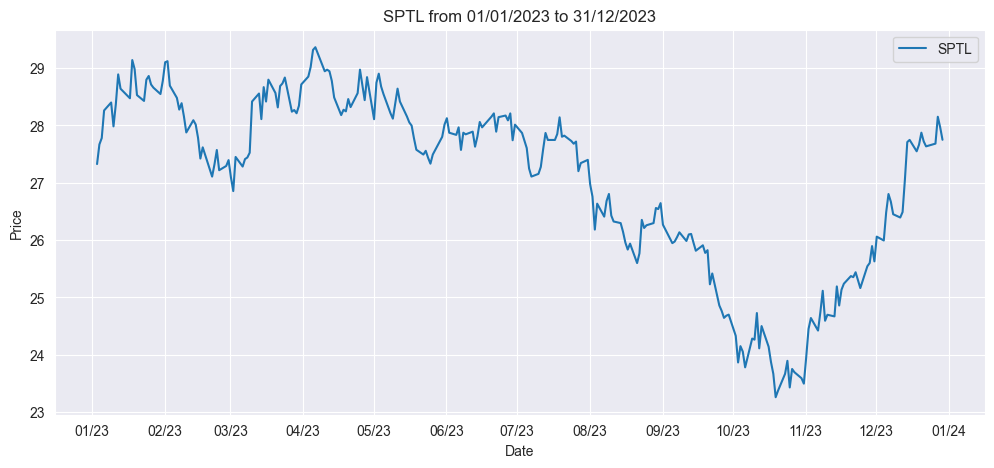

In [335]:
# Visulize overall structure of the data
# Plot relevant numerical columns against Close price
plt.figure(12, figsize=(12,5))
plt.plot(yf_df['Date'], yf_df['Close'])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.title(f'{SPTL_TICKER} from {start_formatted} to {end_formatted}')
plt.legend([SPTL_TICKER])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)